# Imports

In [1]:
# help here: 
#  - https://www.youtube.com/watch?v=nNvPvvuPnGs 
#  - https://github.com/rsreetech/LDATopicModelling/blob/main/LDADemo.ipynb

import os
import time
import math
import warnings
from IPython.display import clear_output, HTML

import numpy as np
import pandas as pd
from pandarallel import pandarallel

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from wordcloud import WordCloud
import pprint

from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter

import nltk
from nltk.corpus import stopwords

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim

# Configuration

In [27]:
# PREVIEW PHASE
PREVIEW_REVIEW_SIZE = 1000

# EXTRACT PHASE
CHUNK_SIZE = 10000
EXTRACT_PARQUET = True

# PREPROCESS IMAGES PHASE
PREPROCESS_IMAGES = False

# SAMPLINg
SAMPLING_REVIEW_SIZE = 1000
SAMPLING_PHOTOS_SIZE = 100

ORIGINAL_DATASET_DIR = 'data/original/yelp_dataset/'
ORIGINAL_PHOTOS_DIR = 'data/original/yelp_photos/'
WORK_DATASET_DIR = 'data/work/yelp_dataset/'
WORK_PHOTOS_DIR = 'data/work/yelp_photos/'

PREFIX_YELP = 'yelp_academic_dataset_'

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=matplotlib.MatplotlibDeprecationWarning)

sns.set()
pandarallel.initialize(progress_bar=True, verbose=False)

# Trick for jupyter lab with pyLdaVis
css_str = """<style> 
    .jp-Button path { fill: var(--jp-inverse-layout-color3);}
    .lm-TabBar-tabIcon path { fill: var(--jp-inverse-layout-color3);}
    .jp-icon-warn0 path {fill: var(--jp-inverse-layout-color3);}
    .bp3-button-text path {    fill: var(--jp-inverse-layout-color3);}
    .jp-icon-brand0 path { fill: var(--jp-inverse-layout-color3);}
    text.terms { fill: var(--jp-inverse-layout-color3);}
</style>"""  
display(HTML(css_str))

# Extractions des sujets des reviews

In [5]:
def list_files(dir, extension='json', print_result = True):
    paths = {(file.split('.')[0]).split(PREFIX_YELP)[1]: dir + file for file in os.listdir(dir) if file.endswith('.' + extension)}
    if print_result:
        files = [[os.path.basename(paths[name]), file_size(paths[name])] for name in paths]
        print(tabulate(files, headers=['Name', 'Size']))
    return paths

def file_size(path, unit='Gb', precision=2, only_value = False):
    exp = 3
    if (unit=='ko'):
        exp = 1
    elif (unit == 'Mb'):
        exp = 2
    else:
        exp = 3
        unit = 'Gb'

    value = round((os.path.getsize(path)/(1024**exp)), precision)
    if only_value:
        return value
    else:
        return str(value) + unit

def preview_dataset(path):
    df = pd.read_json(path, lines=True, nrows=PREVIEW_REVIEW_SIZE)
    display(df.sample(5))
    display(df.dtypes)

    return df   

## Prévisualiastions des datasets

In [6]:
files = list_files(ORIGINAL_DATASET_DIR)
print('')
print(tabulate([[k,v] for k,v in files.items()]))

Name                                 Size
-----------------------------------  ------
yelp_academic_dataset_business.json  0.11Gb
yelp_academic_dataset_checkin.json   0.27Gb
yelp_academic_dataset_review.json    4.98Gb
yelp_academic_dataset_tip.json       0.17Gb
yelp_academic_dataset_user.json      3.13Gb

--------  --------------------------------------------------------------
business  data/original/yelp_dataset/yelp_academic_dataset_business.json
checkin   data/original/yelp_dataset/yelp_academic_dataset_checkin.json
review    data/original/yelp_dataset/yelp_academic_dataset_review.json
tip       data/original/yelp_dataset/yelp_academic_dataset_tip.json
user      data/original/yelp_dataset/yelp_academic_dataset_user.json
--------  --------------------------------------------------------------


In [7]:
preview_dfs = {}
for name in files:
    print(f'PREVIEW {name}\n=====================\n')
    preview_dfs[name] = preview_dataset(files[name])
    print('')

PREVIEW business



,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
530,uU9h_l5WSTY8fKVU2nx2Cw,Foolish Pride Tattoo Company,3100 1st Ave N,St. Petersburg,FL,33713,27.771574,-82.675619,4.5,36,1,"{'BusinessParking': '{'garage': False, 'street...","Beauty & Spas, Tattoo","{'Tuesday': '12:0-20:0', 'Wednesday': '12:0-20..."
613,Iipfa9Kaac9XH5Vo8GQwvg,Starbucks,5956 153 Avenue,Edmonton,AB,T5Y 2W1,53.616147,-113.432424,3.5,10,1,"{'BusinessParking': '{'garage': False, 'street...","Coffee & Tea, Food","{'Monday': '5:30-22:0', 'Tuesday': '5:30-22:0'..."
296,Pr_Mlt9FqdcW7WCFGJmozA,The Cider Factory,420 S B St,Virginia City,NV,89440,39.305224,-119.652596,4.5,104,1,"{'RestaurantsGoodForGroups': 'True', 'GoodForK...","Italian, Seafood, American (Traditional), Stea...","{'Monday': '11:0-19:0', 'Tuesday': '11:0-19:0'..."
788,iEDyJb1Hlouy3jkLX4Oocw,Cooper Medical Center,"6th & Stevens, Ste vens",Camden,NJ,08102,39.941645,-75.116872,3.0,8,1,"{'ByAppointmentOnly': 'False', 'BusinessAccept...","Health & Medical, Hospitals, Medical Centers",None
479,rR30b1XWbxZFFgLyGbfNAw,BODHI : Craft Bar + Thai Bistro,922 Massachusetts Ave,Indianapolis,IN,46202,39.780220,-86.141803,4.5,132,1,"{'Ambience': '{u'divey': False, u'hipster': Fa...","Gastropubs, Nightlife, Restaurants, Thai, Bars...","{'Monday': '0:0-0:0', 'Wednesday': '17:0-22:0'..."


business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object


PREVIEW checkin



,business_id,date
506,-E2h36etKkz5AbIMaoOYWQ,"2015-08-07 22:53:03, 2015-08-16 01:28:09, 2016..."
594,-H6a4mIT5GbQiiWZz2luOw,"2015-10-26 16:51:26, 2018-05-24 16:09:54, 2019..."
243,-6MEKOmFu6jckT3pruSxHg,"2010-06-14 03:35:45, 2010-06-14 23:52:34, 2010..."
449,-CRjqZ4GxZ6lIa_qMj7-yw,"2012-03-05 05:48:39, 2012-04-17 04:48:41, 2012..."
140,-2oyyfOSHs1UElr3Dc1aKQ,"2010-09-04 15:50:22, 2010-12-30 04:09:38, 2011..."


business_id    object
date           object
dtype: object


PREVIEW review



,review_id,user_id,business_id,stars,useful,funny,cool,text,date
417,cvL4g3ycHGJIA2azYMnkHw,-u1pc6o7QmtdrN5i23CIng,oLc7k78_YcDMnMCdbC-h1A,4,0,0,0,Very friendly staff and nice environment altho...,2017-04-19 12:08:34
622,njO5cv6jDieJ9FFPN3DStg,GSKPa1JkF9UwfakvNyIv7A,5rryuz2myZJI0EfWtrTMxw,2,0,0,0,Waited 27 minutes for three teas (no one else ...,2018-01-21 17:12:54
441,3djwsoWuYzfE8VD3jlNd8Q,WDtfOTjdeTgsjqVwFAeqIw,I6L0Zxi5Ww0zEWSAVgngeQ,4,1,0,0,"A nice alternative to Cafe du Monde, the beign...",2015-07-17 00:12:43
553,F_qeQJ7BH1mmxoI_l1WuMA,1M1HMZO1_TuTS5tQbHKIgg,jULIPydhMj18KOI5OHTwfA,3,0,0,0,Fast. Fresh. The carne was very good. So wa...,2017-05-14 12:06:06
736,g8bYpcVdj3tItU7v3ntOzQ,KfOG8p1WKeKpud3TzNGnmg,Zx7n8mdt8OzLRXVzolXNhQ,4,0,0,0,A great restaurant to take people visiting fro...,2018-05-28 20:45:22


review_id              object
user_id                object
business_id            object
stars                   int64
useful                  int64
funny                   int64
cool                    int64
text                   object
date           datetime64[ns]
dtype: object


PREVIEW tip



,user_id,business_id,text,date,compliment_count
108,WhjYxQIiAIZPkVqUqSBDbg,LG80KAbnjI3fICP99UE9RQ,"The people here are rude,",2017-06-23 23:03:51,0
720,vimEpZnvi38O0Vz5uaNj4g,8da9PKeUV44KoUUlYNTVOA,"Green chili blue cheese brats, chipotle chedda...",2013-06-02 00:33:46,0
474,LhfQ_oQZc4XJvthM5ueoJQ,nHuB7fg6XbH9v1aLnlf0Zg,Mama's Lasagna... Magnifico ;-),2010-12-28 21:21:41,0
623,EIPN7GwMqVO9IJV1TKPTRA,3vQNIt7SakHj9YZIhHbJHw,Very friendly. Can drop off for all services: ...,2013-05-25 22:47:06,0
865,7ZauzmeTHuR-8FqnmJbOtA,-qk__vjJxfJrCWn3UaMv_Q,I find the appetizers I ordered are filling. T...,2013-05-18 21:18:37,0


user_id                     object
business_id                 object
text                        object
date                datetime64[ns]
compliment_count             int64
dtype: object


PREVIEW user



,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
328,s5o6DQgvrnmJlbw2IDM9zQ,Jenn,29,2008-07-29 22:48:12,59,344,14,,"Rdg-ifdUSlBfY1XMStuPag, EUoXFWWWeVJMb7AYtvaiYg...",2,...,0,0,0,0,0,1,3,3,0,0
252,1-gnHNzZNbn8lFwYRF_CtA,Liz,112,2011-09-13 13:25:17,563,206,256,"2012,2013,2014","foGHg4xXI5dwpvNZokN8Zw, qPdg4zBfVytSiZh_1-JkSA...",36,...,2,2,2,0,38,38,35,35,20,9
587,dkkMQorZE0EF-F5wOiqA7w,Danielle,266,2006-05-21 03:09:59,283,127,216,"2006,2007,2008","om5ZiponkpRqUNa3pVPiRg, VK-ds3dGSSBoavkFde3e2Q...",23,...,6,2,6,0,15,26,36,36,7,5
984,pQjNCZ3-QZXPtgVeXcKCXQ,Asia,59,2010-04-29 04:59:13,244,143,197,"2018,2019","ceW__oSSMczMSCw4Urc2Xg, zHQySV8lU6GekjzUt-shhA...",20,...,4,0,0,0,7,13,33,33,7,5
202,5HGbhAzCXDngWSTckGBtuA,Jeremy,18,2011-07-23 19:51:14,38,13,4,,"2VF__43nDYaJJwLmTW1hBA, qbdSRR_dRIuXVhdQ9ytW8A...",1,...,0,0,0,0,0,1,0,0,0,0


user_id                object
name                   object
review_count            int64
yelping_since          object
useful                  int64
funny                   int64
cool                    int64
elite                  object
friends                object
fans                    int64
average_stars         float64
compliment_hot          int64
compliment_more         int64
compliment_profile      int64
compliment_cute         int64
compliment_list         int64
compliment_note         int64
compliment_plain        int64
compliment_cool         int64
compliment_funny        int64
compliment_writer       int64
compliment_photos       int64
dtype: object

<Axes: xlabel='stars'>

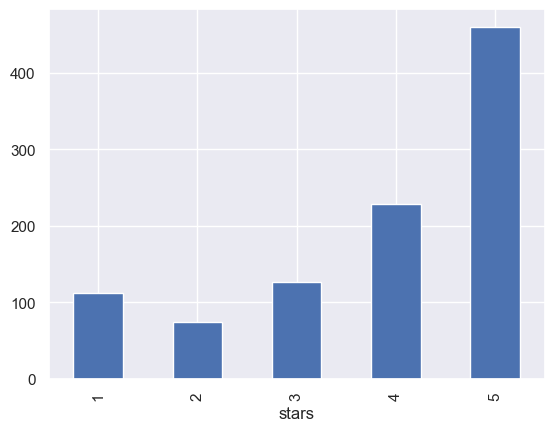

In [8]:
preview_dfs['review']['stars'].value_counts().sort_index().plot.bar()

In [9]:
preview_dfs['business']['categories'].unique()[0:20]

array(['Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists',
       'Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services',
       'Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores',
       'Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries',
       'Brewpubs, Breweries, Food',
       'Burgers, Fast Food, Sandwiches, Food, Ice Cream & Frozen Yogurt, Restaurants',
       'Sporting Goods, Fashion, Shoe Stores, Shopping, Sports Wear, Accessories',
       'Synagogues, Religious Organizations',
       'Pubs, Restaurants, Italian, Bars, American (Traditional), Nightlife, Greek',
       'Ice Cream & Frozen Yogurt, Fast Food, Burgers, Restaurants, Food',
       'Department Stores, Shopping, Fashion',
       'Vietnamese, Food, Restaurants, Food Trucks',
       'American (Traditional), Restaurants, Diners, Breakfast & Brunch',
       'General Dentistry, Dentists, Health & Medic

In [10]:
review = preview_dfs['review']
for star in range(1,6):
    title = HTML(f'<h3 style="">Note = {star}<br><hr></h3>')
    display(title)
    for index in review[review['stars']==star].sample(2, random_state=0).index:
        stars, text = review.loc[index, ['stars', 'text']].values
        quote = HTML(f'<div style="border-left: 4px solid yellow; padding-left:10px; margin-bottom:20px;">{text}</div>')
        display(quote)

<Axes: xlabel='class'>

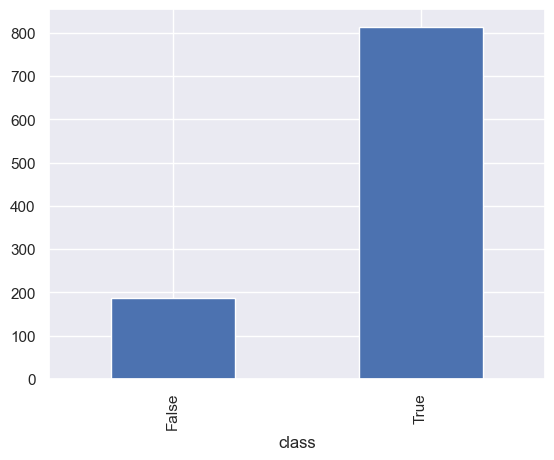

In [11]:
bad_stars = 2
preview_dfs['review']['class'] = preview_dfs['review']['stars'] > bad_stars
preview_dfs['review']['class'].value_counts().sort_index().plot.bar()

In [12]:
sampling_coef_bad = preview_dfs['review']['class'].value_counts()[False]/preview_dfs['review']['class'].value_counts()[True]
print(f'{sampling_coef_bad*100:.0f}% des reviews ont au maximum {bad_stars} étoiles')

23% des reviews ont au maximum 2 étoiles


## Extraction d'un échantillons de reviews

### Recensement des catégories de business

In [13]:
business = pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'business.json', lines=True)
business['_cats'] = business['categories'].apply(lambda x: [cat.strip() for cat in x.split(',')] if x else [])
business['_cats'].sample(5)

101706                     [Sandwiches, Restaurants, Delis]
35394     [Permanent Makeup, Nail Salons, Hair Removal, ...
148187    [Cosmetic Dentists, Health & Medical, General ...
1751                           [Nail Salons, Beauty & Spas]
146271      [Barbers, Beauty & Spas, Hair Salons, Day Spas]
Name: _cats, dtype: object

In [14]:
categories = set()
for index in business.index:
    categories.update(business.loc[index, '_cats'])

In [15]:
[categorie for categorie in categories if 'restaurant' in categorie.lower()]

['Pop-Up Restaurants', 'Restaurants', 'Restaurant Supplies']

In [16]:
[categorie for categorie in categories if 'food' in categorie.lower()]

['Seafood Markets',
 'Imported Food',
 'Ethnic Food',
 'Fast Food',
 'Live/Raw Food',
 'Food Stands',
 'Food',
 'Seafood',
 'Soul Food',
 'Food Delivery Services',
 'Food Banks',
 'Do-It-Yourself Food',
 'Specialty Food',
 'Comfort Food',
 'Food Tours',
 'Food Court',
 'Food Trucks']

### Création des fichiers parquets

- par chunk de 100000
- Filtrage des reviews sur categorie "restaurants"
- Séparation par note
- Ajout des infos business
- Limite en quantité

In [17]:
restaurants_ids = business[~business['categories'].isna() & business['categories'].str.contains('Restaurants')]['business_id'].to_list()
print(f'{len(restaurants_ids)} business sont des Restaurants')

52268 business sont des Restaurants


In [18]:
reviews_files = {stars:WORK_DATASET_DIR + f'reviews_stars_{stars}.parquet' for stars in range(1,6)}
reviews_counts = {stars:0 for stars in range(1,6)}
reviews_append = {stars:False for stars in range(1,6)}

business['review_count_q'] = pd.qcut(business.review_count, q=4, labels=['c1', 'c2', 'c3', 'c4'])
if EXTRACT_PARQUET:
    for chunk in pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'review.json', lines=True, chunksize=10000):
        restaurant_reviews = chunk[chunk['business_id'].isin(restaurants_ids)].copy()
        restaurant_reviews = restaurant_reviews.join(business.set_index('business_id'), on='business_id', rsuffix='_business')

        for stars in reviews_counts:
            if reviews_counts[stars] < SAMPLING_REVIEW_SIZE:
                reviews = restaurant_reviews[restaurant_reviews['stars'] == stars]
                keep_rows = min(SAMPLING_REVIEW_SIZE - reviews_counts[stars], reviews.shape[0])
                reviews_counts[stars] = reviews_counts[stars] + keep_rows
                reviews.iloc[:keep_rows].to_parquet(reviews_files[stars], engine='fastparquet', append=reviews_append[stars])
                reviews_append[stars] = True

        if sum([reviews_counts[i] for i in reviews_counts]) == SAMPLING_REVIEW_SIZE*len(reviews_counts): break

def get_reviews(max_stars = 2, stars = None):
    if stars:
        return pd.read_parquet(reviews_files[stars])
        
    df = pd.DataFrame()
    for stars in range(1, max_stars + 1):
        df = pd.concat([df, pd.read_parquet(reviews_files[stars])])
    return df

In [19]:
print(f'Exemple de dataFrame contenant les enregistrements qui ont au maximum {bad_stars} étoiles')
get_reviews(max_stars=bad_stars).sample(5)

Exemple de dataFrame contenant les enregistrements qui ont au maximum 2 étoiles


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,name,...,latitude,longitude,stars_business,review_count,is_open,attributes,categories,hours,_cats,review_count_q
index,,,,,,,,,,,,,,,,,,,,,
8166,2NctoaTrXaYfRmw_EVREdA,3zCEPQJxa7nb1ofLo7FJTQ,DJJtybSWY0BygESsSrabqg,1,1,0,0,"Food is good, however if your attitude stinks ...",2017-01-02 17:06:36,Texas Wieners,...,39.924335,-75.170818,4.0,42,0,"b'{""OutdoorSeating"":""False"",""RestaurantsAttire...","Breakfast & Brunch, Restaurants, American (Tra...","b'{""Monday"":""10:0-17:0"",""Tuesday"":""10:0-17:0"",...","b'[""Breakfast & Brunch"",""Restaurants"",""America...",c4
14738,PCYStQ6680TUowggTDvMqg,4PhTJHRDmWxWL6zHFoaO8A,g2tZiRNl9Yyo1KWPkvrx7w,2,0,0,0,Oh my goodness you are a coffee and donut shop...,2016-09-30 19:27:42,Dunkin',...,38.772639,-90.492055,1.5,54,1,"b'{""BikeParking"":""False"",""BusinessParking"":""{\...","Coffee & Tea, Donuts, Food, Restaurants, Bagel...","b'{""Monday"":""5:0-22:0"",""Tuesday"":""5:0-22:0"",""W...","b'[""Coffee & Tea"",""Donuts"",""Food"",""Restaurants...",c4
1381,xIxA5HwBDFR1nkGhtKriWg,aNZAEA46mp0TP-L59UHJiA,HCbJPXWXvwN-C7XfmVy3gA,2,0,0,0,I've dined here several times but the last two...,2017-06-06 22:20:23,Granite City Food & Brewery,...,39.766420,-86.159245,3.5,258,0,"b'{""RestaurantsGoodForGroups"":""True"",""Ambience...","Desserts, Breweries, Breakfast & Brunch, Resta...","b'{""Monday"":""11:0-18:0"",""Tuesday"":""11:0-0:0"",""...","b'[""Desserts"",""Breweries"",""Breakfast & Brunch""...",c4
2296,U7cWd7zaEl_X_TOJFgD9fQ,-4Pvmnz9Mej98xiz1w-FRQ,1DFvkUjtsqNRNlORaUYlFQ,2,0,0,0,Hungry hungry! Still hungry!\n\nVery cute and ...,2010-01-08 02:04:05,Warsaw Cafe,...,39.947091,-75.168216,3.0,27,0,"b'{""Alcohol"":""u\'full_bar\'"",""OutdoorSeating"":...","Modern European, Polish, Restaurants",None,"b'[""Modern European"",""Polish"",""Restaurants""]'",c3
4651,Gb5Ssf1Ep_S4KKtJNjfzhw,StccN_zGJu35vnBBpNIIGQ,s8KNTkHGjMnzx5zcnWBbwQ,1,0,0,0,The tomato soup was great. \nBut my pizza...wo...,2018-02-23 22:55:44,Famoso,...,53.598225,-113.573125,3.5,60,0,"b'{""HasTV"":""True"",""BikeParking"":""True"",""Restau...","Italian, Restaurants, Pizza","b'{""Monday"":""11:0-22:0"",""Tuesday"":""11:0-22:0"",...","b'[""Italian"",""Restaurants"",""Pizza""]'",c4


## Analyse des echantillons de reviews 

### Fonctions de traitement du text

In [20]:
def get_negative_sw():
    return [sw for sw in stopwords.words('english') if sw not in ['not', 'too', 'very', 'few',  "don't", "aren't", 'couldn',
                                                                  "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                                                                  "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn',
                                                                  "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn',
                                                                  "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
                                                                  "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
           ]

def drop_words(tokens, words):
    return [token for token in tokens if token not in words]

def preprocess_text(text):
    # normalization
    text = text.lower().strip()

    return text 

def tokenize(text):
    from nltk import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    # Tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)

    # Lematization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='a') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='n') for word in tokens]

    # Keep tokens with length > 2
    tokens = [token for token in tokens if len(token) > 2]

    return tokens

def extract_n_grams(token_list, n_list):
    import nltk
    n_grams = []
    for n in n_list:
        n_grams.append([' '.join(n_gram) for n_gram in nltk.ngrams(token_list,n)])

    new_token_list = []
    for n_gram in n_grams:
        new_token_list  = new_token_list + n_gram

    if 1 in n_list:
        new_token_list = token_list + new_token_list

    return new_token_list    
    
def display_word_cloud(reviews, no_below = 4, no_above = 0.1, max_words_in_cloud=50, verbose = 0):

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')

    if verbose > 0: display(reviews.sample(5, random_state=0).loc[:, ['stars', 'text']])
    
    # Initialize paralellize and sampling
    pandarallel.initialize(progress_bar=(verbose > 0), verbose=False)
    
    # Preprocess
    if verbose > 0: print('\nPreprocess\n=================\n')
    reviews['text'] = reviews['text'].parallel_apply(preprocess_text)

    # Preprocess (tokenize, lemmatization)
    if verbose > 0: print('\nTokenize\n=================\n')
    reviews['tokens'] = reviews['text'].parallel_apply(tokenize)
    reviews.drop(columns=['text'], inplace=True)

    stop_words = get_negative_sw()
    reviews['tokens'] = reviews['tokens'].parallel_apply(drop_words, args=(stop_words,))
    reviews['text_len'] = reviews['tokens'].str.join(' ').str.len()

    if verbose > 0:
        print('')
        tokens_infos = [
            ['Nombre de tokens unique initial dans le dataframe', nb_words_original],
            ['Nombre de stopwords', len(stop_words)],
            ['Nombre de tokens unique restant dans le dataframe', len(set(reviews['tokens'].sum()))]
        ]
        print(tabulate(tokens_infos))

    # View result sample
    if verbose > 0: 
        print('\nEchantillon du resultat\n=================\n')
        display(reviews.sample(5, random_state=0).loc[:, ['stars', 'tokens']])

    # Calc and view text lengths
    if verbose > 0: 
        print('\nAnalyse des longeurs de text\n=================\n')
        reviews.boxplot(column='text_len', showfliers=True, vert=False)
        plt.show()

    # Text length
    total_text_len = reviews['text_len'].sum()
    if verbose > 0: 
        print(f'Longeur total du texte dans le dataframe: {total_text_len}')
        print('')

    # Visualisation Word clound on sample
    # Sampling for word cloud
    cloud_sample_size = min(reviews.shape[0], 1000)
    sample = reviews.sample(cloud_sample_size, random_state=0)['tokens']

    # Filter extremes filter
    dictionary = corpora.Dictionary(list(sample))
    dictionary.filter_extremes(no_below=2, no_above=0.1)
    sample.parallel_apply(lambda tokens: [token for token in tokens if token in list(dictionary.values())])
    
    if verbose > 0: print(f'\nVisualisation du nuage de mot d\'un échantillon de {cloud_sample_size} lignes\n=================\n')

    # Join text and display wordcloud
    sample_text = ' '.join(sample.str.join(' ').values)
    wordcloud = WordCloud(background_color = 'white', max_words = max_words_in_cloud).generate(sample_text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();
    print('')

### Nuages de mots par note

Note = 5


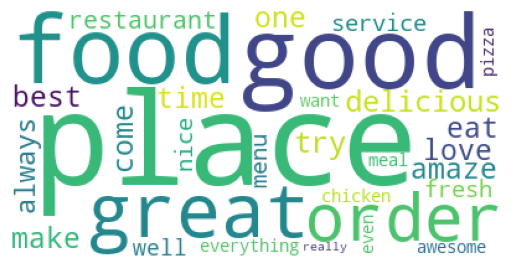


Note = 4


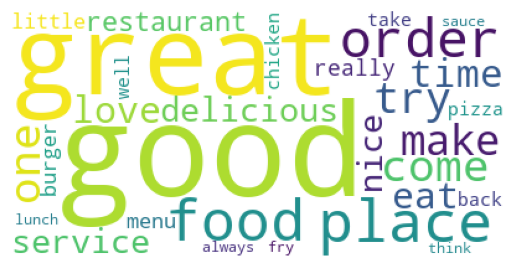


Note = 3


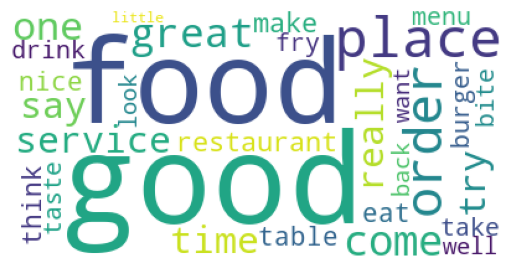


Note = 2


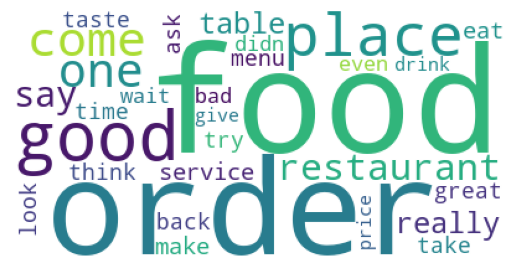


Note = 1


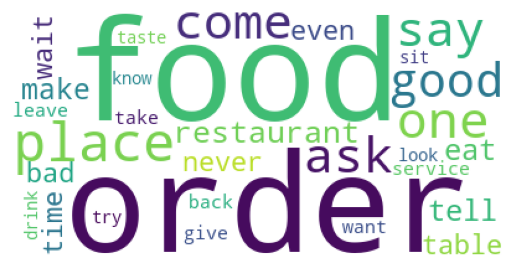

In [21]:
for stars in range(5,0,-1):
    print(f'Note = {stars}')
    display_word_cloud(reviews=get_reviews(stars=stars),
                       no_below=2,
                       no_above= 0.3, 
                       max_words_in_cloud=30)

## Recherche des sujets d'insatisfactions

### Sac de mots (TF-IDF)

In [22]:
def tf_idf(reviews, min_df = 4, max_df = 100, ngram_range=(1,2), verbose = 0):

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')
    
    if verbose > 1: display(reviews.sample(5, random_state=0))


    vectorizer = TfidfVectorizer(tokenizer=tokenize, token_pattern=None, preprocessor=preprocess_text, min_df=min_df, max_df=max_df, stop_words=get_negative_sw(), sublinear_tf=True,ngram_range=ngram_range)
    values = vectorizer.fit_transform(reviews['text'])

    if verbose > 0:
        print('\nVecteurs TF-IDF des reviews:\n====================')
        df = pd.DataFrame(values.toarray(), columns=vectorizer.get_feature_names_out())
        display(df.head())
        
        reviews_vecteurs = []
        reviews.reset_index(inplace=True)
        for index in reviews[reviews['text'].str.len() < 500].sample(5, random_state=0).index:
            review_tfidf = df.iloc[index][df.iloc[index] > 0].to_dict()
            reviews_vecteurs.append([reviews.iloc[index]['text'] , '\n'.join([f'{token}: {tfidf:.4f}' for token, tfidf in review_tfidf.items()])])
        print(tabulate(reviews_vecteurs, headers=['text review', 'vecteur tf-idf'], tablefmt="grid", maxcolwidths=[100, None]))

    return values, vectorizer.get_feature_names_out()

In [23]:
print(f'Vectorisation pour les reviews comportant maximum {bad_stars} étoiles')
reviews = get_reviews(max_stars=bad_stars)
values, features_names = tf_idf(reviews=reviews,
                                min_df=10,
                                max_df=0.1,
                                ngram_range=(1,2),
                                verbose=1)

Vectorisation pour les reviews comportant maximum 2 étoiles
Nombre de textes dupliqués supprimés: 0
Il y a 2000 enregistrements

Vecteurs TF-IDF des reviews:


,100,1st,2nd,able,absolute,absolutely,accept,accommodate,acknowledge,across,...,yelp,yes,yesterday,yet,york,young,yuck,yummy,zero,zero star
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.231769,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.176228,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


+------------------------------------------------------------------------------------------------------+--------------------------+
| text review                                                                                          | vecteur tf-idf           |
+======================================================================================================+==========================+
| You don't accept cash?  I don't think you grasp the ramifications of such a corpo-fascist economic   | accept: 0.2965           |
| principle.  No room for arrogant commies in my diet thank you so very very little.  Can't wait to    | anyone: 0.2395           |
| see this place nosedive  For anyone in the dark about this policy,  watch Mike Judge's film,         | attention: 0.2499        |
| Idiocracy. Pay close attention throughout the hospital scene.   "Unscannable!!!"                     | cash: 0.2758             |
|                                                                           

### LDA / NMF Librairie Sklean

In [24]:
def get_topics(reviews: pd.DataFrame, min_df = 4, max_df = 10, n_topics = 10, alpha = 10, n_top_words = 10, ngram_range=(1,1), verbose = 0):

    # pandas width
    pd_width = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 300)
    
    if verbose > 1: print('  - Vectorisation (tf-idf)')
    values, features_names = tf_idf(reviews=reviews, min_df=min_df, max_df=max_df, ngram_range=ngram_range, verbose = 0)

    # Topics from LDA or MDF
    if verbose > 1: print('  - Modélisation LDA')
    model = LatentDirichletAllocation(n_components=n_topics,
                                      max_iter=10,
                                      doc_topic_prior=alpha,
                                      learning_method='online', 
                                      learning_offset=10,
                                      random_state=0,
                                      n_jobs=-1)
    
    model.fit(values)

    if verbose > 1: print('  - Affichage des topics\n')
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        features = [features_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append([topic_idx, ', '.join(features)])
    
    if verbose > 0: print(tabulate(topics, headers=['Topic n°', 'Categories']))

    # Restore pandas width
    pd.set_option('display.max_colwidth', pd_width)

    return topics

In [29]:
params = {
    'max_stars': bad_stars,
    'min_df': 2,
    'max_df': 0.1,
    'n_topics': 5,
    'alpha': 0.5,
    'n_top_words': 5,
    'ngram_range': (1,1)
}

print(f'Recherche des sujets avec les paramètres suivants:\n')
print(tabulate([[name, value] for name, value in params.items()], headers=['param', 'valeur']))
print('')
topics = get_topics(reviews=get_reviews(max_stars=bad_stars),
                    min_df=params['min_df'],
                    max_df=params['max_df'],
                    n_topics=params['n_topics'], 
                    alpha=params['alpha'],
                    n_top_words=params['n_top_words'],
                    ngram_range=params['ngram_range'],
                    verbose=3)

Recherche des sujets avec les paramètres suivants:

param        valeur
-----------  --------
max_stars    2
min_df       2
max_df       0.1
n_topics     5
alpha        0.5
n_top_words  5
ngram_range  (1, 1)

  - Vectorisation (tf-idf)
  - Modélisation LDA
  - Affichage des topics

  Topic n°  Categories
----------  --------------------------------------------
         0  pizza, waitress, burger, sauce, bar
         1  mahi, gun, trio, uncooked, surly
         2  bueno, wifi, liver, fancy, performance
         3  refer, 312, tony, denny, angelo
         4  initially, expense, goopy, preference, legit


In [31]:
params['alpha'] = 0.2
params['max_df'] = 0.2
params['ngram_range'] = (3,3)

print(f'Recherche des sujets avec les paramètres suivants:\n')
print(tabulate([[name, value] for name, value in params.items()], headers=['param', 'valeur']))
print('')
topics = get_topics(reviews=get_reviews(max_stars=bad_stars),
                    min_df=params['min_df'],
                    max_df=params['max_df'],
                    n_topics=params['n_topics'], 
                    alpha=params['alpha'],
                    n_top_words=params['n_top_words'],
                    ngram_range=params['ngram_range'],
                    verbose=3)

Recherche des sujets avec les paramètres suivants:

param        valeur
-----------  --------
max_stars    2
min_df       2
max_df       0.2
n_topics     5
alpha        0.2
n_top_words  5
ngram_range  (3, 3)

  - Vectorisation (tf-idf)
  - Modélisation LDA
  - Affichage des topics

  Topic n°  Categories
----------  ------------------------------------------------------------------------------------------
         0  would not recommend, food good not, not recommend place, not impress food, could give zero
         1  waste time money, not worth price, food mediocre best, make feel like, get order wrong
         2  food nothing special, get money back, happy hour menu, nothing write home, take one bite
         3  take minute get, not worth wait, never come back, would give star, take drink order
         4  not very good, want like place, give two star, really want like, service very slow


### LDA Librairie Gensim et optimisation du nombre de sujets

In [32]:
def prepare_data(max_stars=2, n_grams=[1,2], no_below=2, no_above=0.1):
    print('  - Préparation des data (preprocess tokenisation...)')

    # Initialize paralellize and sampling
    pandarallel.initialize(progress_bar=False, verbose=False)
    
    # Preprocess, tokenize and drop stop words
    reviews = get_reviews(max_stars=max_stars)
    texts = reviews['text'].parallel_apply(preprocess_text)
    texts = texts.parallel_apply(tokenize)
    stop_words = get_negative_sw()
    texts = texts.parallel_apply(drop_words, args=(stop_words,))
    
    # Managing n_grams
    texts = texts.parallel_apply(extract_n_grams, args=(n_grams,))

    # list texts
    texts = list(texts)
    
    # create document terms matrix
    dictionary = corpora.Dictionary(texts)
    
    #filter extremes
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)
    
    corpus = [dictionary.doc2bow(text) for text in texts]

    return texts, dictionary, corpus

def modelize(dictionary, corpus, alpha = 10, num_topics = 10):
    print(f'  - LDA pour {num_topics} topics')
    LDA = gensim.models.ldamodel.LdaModel
    model = LDA(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=alpha, random_state=0, chunksize=1000, passes=50,iterations=100)
    return model

def visualize_model(model, corpus, dictionary):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    return vis

def print_topics(model):
    topics = []
    for topic in model.show_topics():
        index = topic[0] + 1
        terms = '\n'.join(topic[1].split(' + '))
        topics.append([index, terms])
    
    print(tabulate(topics, headers=['Topic n°', 'mots clés'], tablefmt="grid"))

In [33]:
texts, dictionary, corpus = prepare_data(max_stars=2, n_grams=[2,3], no_below=2, no_above=0.2)
model = modelize(dictionary=dictionary, corpus=corpus, num_topics=5)
print_topics(model)
vis = visualize_model(model, corpus, dictionary)
vis

  - Préparation des data (preprocess tokenisation...)
  - LDA pour 5 topics
+------------+--------------------------+
|   Topic n° | mots clés                |
+============+==========================+
|          1 | 0.005*"come back"        |
|            | 0.004*"taste like"       |
|            | 0.003*"win back"         |
|            | 0.002*"food not"         |
|            | 0.002*"wait staff"       |
|            | 0.002*"felt like"        |
|            | 0.002*"every time"       |
|            | 0.002*"mac cheese"       |
|            | 0.002*"fast food"        |
|            | 0.002*"mexican food"     |
+------------+--------------------------+
|          2 | 0.004*"look like"        |
|            | 0.003*"not return"       |
|            | 0.003*"even though"      |
|            | 0.002*"not sure"         |
|            | 0.002*"good place"       |
|            | 0.002*"good thing"       |
|            | 0.002*"mash potato"      |
|            | 0.002*"like place"       |


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.148313 -0.097004       1        1  20.580605
0     -0.042846  0.052658       2        1  20.199007
4      0.112619  0.179830       3        1  19.898488
1      0.174357 -0.167909       4        1  19.864926
3     -0.095816  0.032426       5        1  19.456974, topic_info=            Term       Freq       Total Category  logprob  loglift
703    last time  36.000000   36.000000  Default  30.0000  30.0000
139   first time  67.000000   67.000000  Default  29.0000  29.0000
2046  last night  36.000000   36.000000  Default  28.0000  28.0000
97    taste like  95.000000   95.000000  Default  27.0000  27.0000
335    look like  56.000000   56.000000  Default  26.0000  26.0000
...          ...        ...         ...      ...      ...      ...
169     food not  17.790630   52.310808   Topic5  -6.3650   0.5584
71      get food  17.468355   61.615338   Topic5  -6.3833   0.3764
112    didn even  16.063520   43.468071   Topic5  -6.4671   0.6415
63     come back  17.554215  121.905544   Topic5  -6.3784  -0.3010
175     not even  14.987777   48.038694   Topic5  -6.5364   0.4722

[328 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1800      5  0.931457    almost hour
1546      1  0.905917  almost minute
4231      2  0.975568    another try
3677      5  0.918649      ask order
2721      1  0.907344     ask waiter
...     ...       ...            ...
1037      2  0.019768      would not
1037      4  0.019768      would not
1037      5  0.652330      would not
3038      3  0.073455    would think
3038      4  0.881458    would think

[536 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 2, 4])

In [35]:
texts, dictionary, corpus = prepare_data(max_stars=1, n_grams=[3], no_below=2, no_above=0.1)
model = modelize(dictionary=dictionary, corpus=corpus, alpha=20, num_topics=5)
print_topics(model)
vis = visualize_model(model, corpus, dictionary)
vis

  - Préparation des data (preprocess tokenisation...)
  - LDA pour 5 topics
+------------+-----------------------------------+
|   Topic n° | mots clés                         |
+============+===================================+
|          1 | 0.012*"waste time money"          |
|            | 0.011*"never come back"           |
|            | 0.009*"get money back"            |
|            | 0.009*"buy one get"               |
|            | 0.008*"could give zero"           |
|            | 0.008*"would not recommend"       |
|            | 0.008*"take drink order"          |
|            | 0.007*"excite try place"          |
|            | 0.007*"give another chance"       |
|            | 0.007*"come back check"           |
+------------+-----------------------------------+
|          2 | 0.009*"want like place"           |
|            | 0.009*"make eye contact"          |
|            | 0.008*"wish could give"           |
|            | 0.008*"say didn know"             |
|     

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.108142  0.122379       1        1  20.038914
0     -0.090220  0.020157       2        1  20.034222
3      0.078216 -0.038631       3        1  19.990335
4      0.023514 -0.145471       4        1  19.976336
2     -0.119652  0.041566       5        1  19.960192, topic_info=                   Term      Freq      Total Category  logprob  loglift
196      new york pizza  4.000000   4.000000  Default  30.0000  30.0000
385         buy one get  4.000000   4.000000  Default  29.0000  29.0000
570    make eye contact  4.000000   4.000000  Default  28.0000  28.0000
225       take one bite  4.000000   4.000000  Default  27.0000  27.0000
83       get money back  4.000000   4.000000  Default  26.0000  26.0000
..                  ...       ...        ...      ...      ...      ...
214       give one star  1.885274   4.959254   Topic5  -5.3609   0.6442
205      taste like old  1.644798   3.553527   Topic5  -5.4973   0.8411
63      never come back  1.876602  12.071960   Topic5  -5.3655  -0.2500
703  food great service  1.589959   2.839388   Topic5  -5.5312   1.0316
281    call place order  1.572933   2.843788   Topic5  -5.5420   1.0192

[259 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
510       5  0.938971   actually get eat
147       2  0.939829  almost hour drink
71        2  0.939824       ask girl add
182       1  0.176013  ask speak manager
182       3  0.352026  ask speak manager
...     ...       ...                ...
542       3  0.701632   wouldn come back
115       4  0.938681   write bad review
195       2  0.200893    zero star would
195       3  0.200893    zero star would
195       4  0.602678    zero star would

[320 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 5, 3])

# Classifications des images

## Prévisualisation du dataset

In [3]:
df_photos = pd.read_json('data/original/yelp_photos/photos.json', lines=True)
df_photos.sample(5)

,photo_id,business_id,caption,label
109738,qijy0e_2zd3fVFpZP1zC5g,waV7CZw241FjHzOFKh2Juw,,food
34272,sBJdn3GQagB9QADyy-KeoQ,egnC9NBhtUhgl3rr57Ucqw,Renovated Main Bar - Water Wheel Tavern,inside
18313,ImbajH_R7NiuIsTva3rtDg,4Cal2AE6cr7m6nL20Rz2kQ,,inside
174580,4ZCIZGdZ1ft4pmaKNRliQg,CBVr3pi38wKweXVScurtVQ,Homemade Chicken Pot Pie: Scratch-made cream s...,food
103018,j-B8Q207Nz1GVpUSjCSTrQ,3fVYGQr_ldW2_1QlXJjpaQ,Front Porch,drink


In [4]:
df_photos.shape

(200100, 4)

In [5]:
df_photos.label.value_counts()

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64

## Creation dataset echantillons

L'échantillon contient 500 images


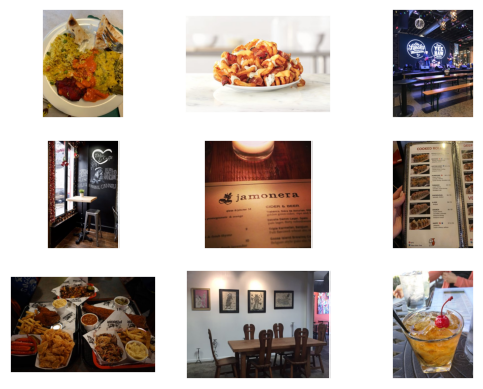

In [6]:
def get_original_photo_path(photo_id):
    return ORIGINAL_PHOTOS_DIR + 'photos/' + photo_id + '.jpg'
    
photo_ids = {}
df_photos_sampling = pd.DataFrame()
for label in df_photos.label.unique():
    photo_ids = list(df_photos[df_photos.label == label].sample(SAMPLING_PHOTOS_SIZE, random_state=0)['photo_id'])
    df_label = pd.DataFrame({
        'photo_id': photo_ids,
        'label': np.full(len(photo_ids), label),
        'width': np.zeros(len(photo_ids)), 
        'height': np.zeros(len(photo_ids)), 
        'mode': np.full(len(photo_ids), '')
    })
    df_photos_sampling = pd.concat([df_photos_sampling, df_label], ignore_index=True)

print(f'L\'échantillon contient {df_photos_sampling.shape[0]} images')

sample_ids = list(df_photos_sampling.sample(9, random_state=1)['photo_id'])
for i in range(9):
    plt.subplot(330 + 1 + i)
    image = matplotlib.image.imread(get_original_photo_path(sample_ids[i]))
    plt.imshow(image)
    plt.grid(linewidth=0)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.show()

In [7]:
def fill_infos(df):
    for index in df.index:
        print(f'Lecture infos image {index+1}/{len(df)}', end='\r')
        photo_id = df.iloc[index]['photo_id']
        img = Image.open(get_original_photo_path(photo_id))
        
        w, h = img.size
        df.loc[df['photo_id']==photo_id, 'height'] = h   
        df.loc[df['photo_id']==photo_id, 'width'] = w
        df.loc[df['photo_id']==photo_id, 'mode'] = img.mode

fill_infos(df_photos_sampling)
df_photos_sampling.sample(5)

,photo_id,label,width,height,mode
218,-Lk0VwJun5Uy3DjTp-bxbQ,drink,588.0,400.0,RGB
148,yCm7da5LBp2LdiXagmVr6A,outside,300.0,400.0,RGB
477,XSikBMuh81inUT5wmnewCg,menu,300.0,400.0,RGB
490,-I9Q_CIBFYu4B05W7Zz6Mw,menu,300.0,400.0,RGB
481,OTyaFoqVrWPtkLZt-D0Ydg,menu,600.0,285.0,RGB


In [8]:
df_photos_sampling.describe()

,width,height
count,500.000000,500.000000
mean,438.882000,389.688000
std,131.985303,32.814085
min,131.000000,69.000000
25%,300.000000,400.000000
50%,408.000000,400.000000
75%,543.750000,400.000000
max,600.000000,400.000000


In [9]:
df_photos_sampling['mode'].value_counts()

mode
RGB    500
Name: count, dtype: int64

## Pretraitement des images

In [10]:
def preprocess_images(df):
    for index in df.index:
        print(f'preprocess image {index+1}/{len(df)}', end='\r')
        photo_id = df.iloc[index]['photo_id']
        preprocess_image(photo_id)

def preprocess_image(photo_id, display_evo = False):
    original_path = get_original_photo_path(photo_id)
    if display_evo:
        img = display_img(original_path)
        img = histo_rgb(img)
    else:
        img = Image.open(original_path)
    
    img = treat_histogram(img)
    img = filter_img(img)
    new_path = save_img(current_path=original_path, img=img)

    if display_evo:
        img = display_img(new_path)
        img = histo_rgb(img)
    
    return new_path
    
def display_img(path):
    img = Image.open(path)
    display(img)
    return img

def histo_rgb(img):
    r, g, b = img.split()
    fig, axs = plt.subplots(1,3, figsize=(10,5), sharey=True)
    chans = {'rouge': r, 'vert': g, 'bleu':b}
    for index, name in enumerate(chans):
        chan_flat = np.array(chans[name]).flatten()
        ax = sns.histplot(chan_flat, bins=range(256), ax=axs[index])
        ax.set(ylabel=None,
               title=f'Channel: {name}')
    fig.supxlabel('Intensité')
    fig.supylabel('Nombre de pixels')
    plt.show()

    return img

def treat_histogram(img):
    # Equalize and autocontrast
    img = ImageOps.equalize(img)
    img = ImageOps.autocontrast(img)
    return img
    

def filter_img(img):
    # Apply gaussian blur
    img = img.filter(ImageFilter.MedianFilter(size=3))
    return img

def save_img(current_path, img):
    filename = os.path.basename(current_path)
    new_path = WORK_PHOTOS_DIR + filename
    img.save(new_path)

    return new_path

### Exemple de pre-traitement

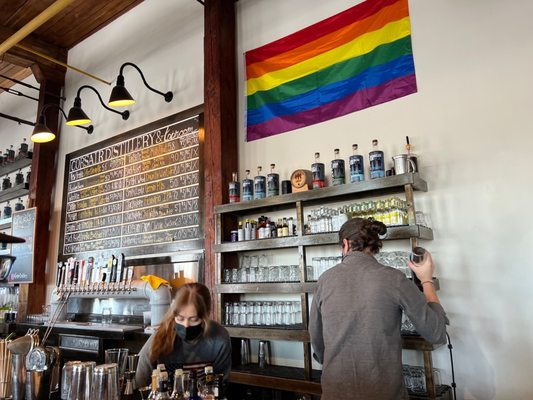

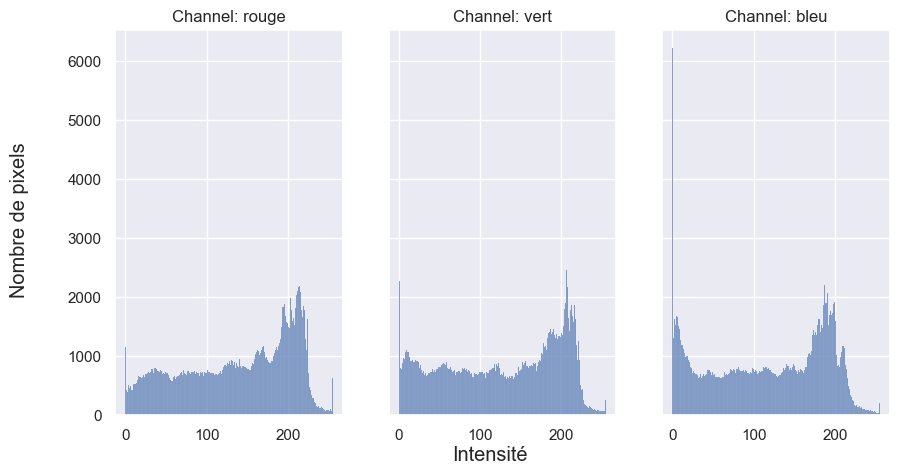

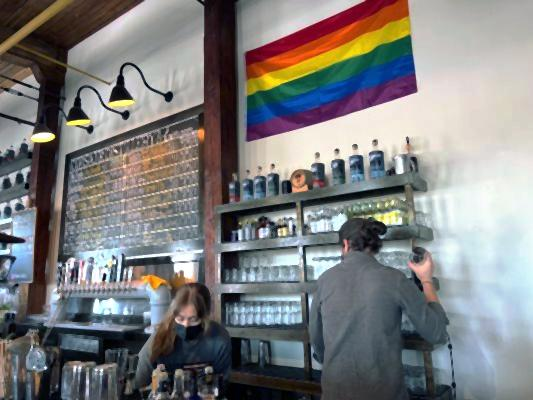

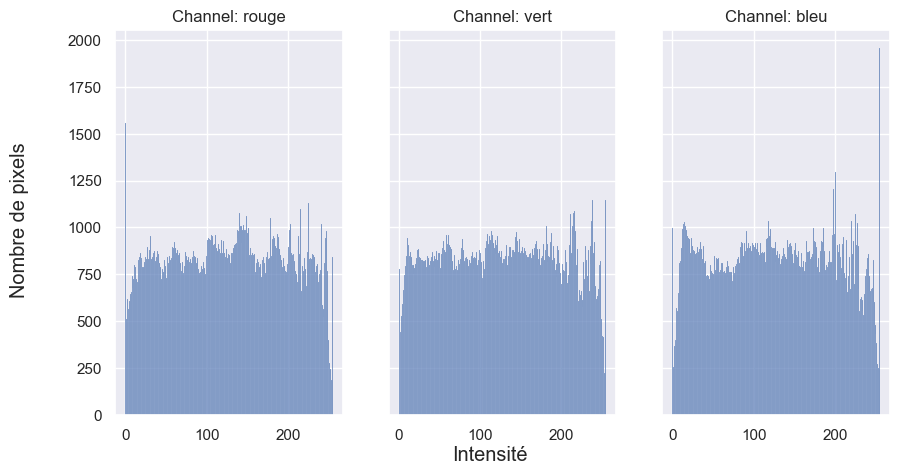

'data/work/yelp_photos/1KfbK9IcrbxY1lUkvN1aUA.jpg'

In [11]:
photo_id_sample = df_photos_sampling.sample(1, random_state=0)['photo_id'].iloc[0]
preprocess_image(photo_id_sample,display_evo=True)

### Pretaitement de l'ensemble de l'échantillon

In [12]:
if PREPROCESS_IMAGES:
    preprocess_images(df=df_photos_sampling)

## Clustering par descripteurs SIFT

### Creation des descripteurs

In [13]:
def get_descripteurs(photo_id, max_desc=500, work_dir = WORK_PHOTOS_DIR, plot = False, print_desc = False):
    import cv2
    sift = cv2.xfeatures2d.SIFT_create(max_desc)
    image = cv2.imread(work_dir + photo_id + '.jpg')
    kp, desc = sift.detectAndCompute(image, None)

    if plot:
        img=cv2.drawKeypoints(image,kp,image)
        plt.imshow(img)
        plt.grid(linewidth=0)
        plt.show()

    if print_desc:
        print("Descripteurs : ", desc.shape)
        print()
        print(desc)
    
    return desc    

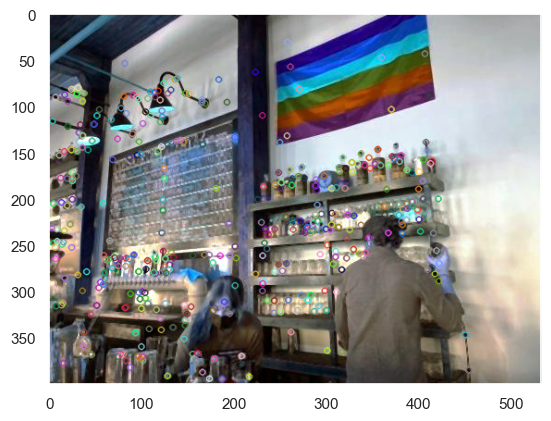

Descripteurs :  (501, 128)

[[ 0.  0.  0. ...  1. 18. 18.]
 [13. 14.  8. ... 24.  0.  1.]
 [24.  0.  0. ...  2.  5. 25.]
 ...
 [ 0.  0.  0. ...  0.  2.  8.]
 [ 0.  0.  0. ...  0.  2. 13.]
 [ 0.  0. 10. ...  0.  0. 12.]]


In [14]:
desc = get_descripteurs(photo_id=photo_id_sample, plot=True, print_desc=True)

In [15]:
pandarallel.initialize(progress_bar=True, verbose=False)
descripteurs = df_photos_sampling['photo_id'].parallel_apply(get_descripteurs, args=(500,))
df_photos_sampling['desc'] = descripteurs
display(df_photos_sampling.sample(3))
num_img_desc = df_photos_sampling['desc'][0].shape[0]

,photo_id,label,width,height,mode,desc
253,rWcHwwSBtC99QAuxoaP4Dw,drink,225.0,400.0,RGB,"[[11.0, 13.0, 61.0, 34.0, 7.0, 19.0, 24.0, 5.0..."
231,let3CWoYbIFV_cGdiIsvYQ,drink,279.0,400.0,RGB,"[[36.0, 6.0, 0.0, 0.0, 0.0, 0.0, 6.0, 24.0, 14..."
181,MiKswe77_PgF2uxjYHRpgw,outside,539.0,400.0,RGB,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 22.0, 51..."


### Clustering des descripteurs

In [16]:
all_descripteurs = np.concatenate(df_photos_sampling['desc'].values, axis=0)
n_clusters = math.floor(math.sqrt(len(all_descripteurs)))
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=512, random_state=0, n_init="auto").fit(all_descripteurs)
print(f'Il y a {n_clusters} clusteurs pour un total de {len(all_descripteurs)} descripteurs')

Il y a 494 clusteurs pour un total de 244742 descripteurs


### Creations des features des images

In [17]:
def features(descripteurs, kmeans: MiniBatchKMeans):
    import numpy as np
    desc_clusters = kmeans.predict(descripteurs)
    return np.histogram(desc_clusters, bins=kmeans.n_clusters, range=(0, kmeans.n_clusters))[0]

features = df_photos_sampling['desc'].parallel_apply(features, args=(kmeans,))
df_photos_sampling['features'] = features
df_photos_sampling.sample(3)

,photo_id,label,width,height,mode,desc,features
329,8jTMLXsKxOAGWtyloxv14A,food,600.0,400.0,RGB,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0...","[0, 9, 1, 1, 1, 0, 1, 0, 1, 4, 0, 0, 0, 0, 3, ..."
306,VA6flQNYSn1jDkNCD0A4Dg,food,600.0,400.0,RGB,"[[18.0, 83.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 66...","[0, 0, 1, 1, 0, 1, 1, 2, 0, 1, 0, 1, 1, 1, 0, ..."
230,hni37T4T6qSctyDsNtd9kQ,drink,224.0,400.0,RGB,"[[1.0, 0.0, 1.0, 1.0, 2.0, 20.0, 54.0, 8.0, 14...","[1, 2, 3, 2, 1, 0, 0, 1, 1, 5, 1, 2, 2, 1, 0, ..."


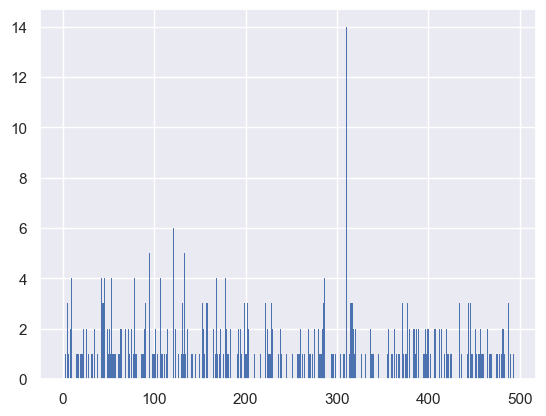

In [18]:
features_sample = df_photos_sampling['features'][0]
plt.bar(range(len(features_sample)), features_sample, linewidth=0)
plt.show()

### Reduction de dimension

In [19]:
keep_variance = 0.99
pca = PCA(n_components=keep_variance, svd_solver='full')
features_pca = pca.fit_transform(list(df_photos_sampling['features']))
new_shape = features_pca.shape[1]
print(f'En concervant {keep_variance*100}% de la variance, la PCA réduit les features de {n_clusters} composantes à {new_shape} composantes') 

En concervant 99.0% de la variance, la PCA réduit les features de 494 composantes à 338 composantes


<Axes: xlabel='x_tsne', ylabel='y_tsne'>

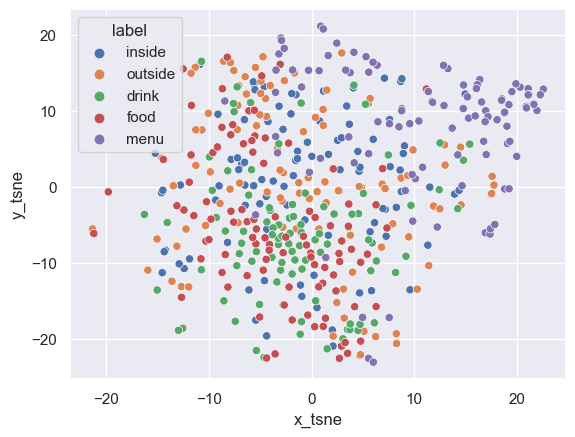

In [20]:
tsne = TSNE(n_components=2, perplexity=20, n_iter=15000, init='random', random_state=0)
X_tsne = tsne.fit_transform(features_pca)

df_photos_sampling['x_tsne'] = X_tsne[:,0:1]
df_photos_sampling['y_tsne'] = X_tsne[:,1:2]

sns.scatterplot(df_photos_sampling, x='x_tsne', y='y_tsne', hue='label')

In [21]:
n_clusters = df_photos_sampling['label'].nunique()
kmean_final = MiniBatchKMeans(n_clusters=5, batch_size=512, random_state=0, n_init="auto").fit(features_pca)
images_clusters = kmean_final.predict(features_pca)

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_photos_sampling['label_num'] = label_encoder.fit_transform(df_photos_sampling['label'])

conf_mat = confusion_matrix(list(df_photos_sampling['label_num']), images_clusters)
print(conf_mat)

[[56  3 37  3  1]
 [56  1 43  0  0]
 [18  7 74  1  0]
 [ 4 26 33 36  1]
 [19  8 70  3  0]]


In [24]:
label_encoder.classes_

array(['drink', 'food', 'inside', 'menu', 'outside'], dtype=object)

<Axes: >

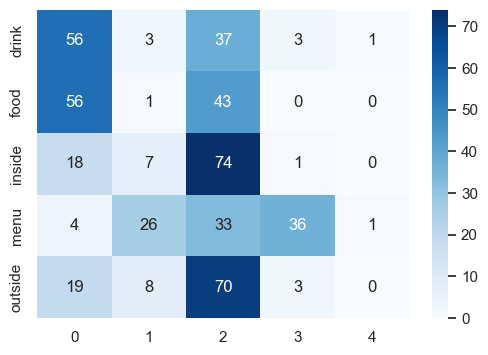

In [25]:
plt.figure(figsize = (6,4))
sns.heatmap(conf_mat, annot=True, cmap="Blues", yticklabels=label_encoder.classes_)

## Clustering par CNN

In [28]:
from keras.applications.vgg16 import VGG16

model = VGG16(include_top=False,) # Création du modèle VGG-16 implementé par Keras